# Q-Robots
To model this problem, we will take the necessary penalty functions. Furthermore, in this modelling, we are going to try to introduce some additional variables that try to improve the performance of our modelling.


We load the libraries that we are going to use.

In [1]:
import qubovert
import math
from neal import SimulatedAnnealingSampler

import numpy as np
import matplotlib.pyplot as plt

The function that we introduce now will calculate what restrictions are not met when a solution is proposed.

In [2]:
#%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'pdf'

We select the values of $ N $ and $ Q $.

In [3]:
N = 6
Q = 2

We show the location of the nodes of the problem that we are going to solve

In [4]:
## We enter by hand the points we want to solve
puntos = np.random.rand(N+1,2)

#puntos[0,:] = 0,0

#puntos[1,:] = 1,1
#puntos[2,:] = 1.1,0.9

#puntos[3,:] = -1,-1.1
#puntos[4,:] = -0.7,-1.2

#puntos[5,:] = -1,1.2
#puntos[6,:] = -1.1,0.9


puntos[0,:] = 0,0

puntos[1,:] = 1,4
puntos[2,:] = 6.1,2.2

puntos[3,:] = -6,-1.1
puntos[4,:] = -9.7,-1.2

puntos[5,:] = -8,4.2
puntos[6,:] = -1.1,3.9





print(puntos)

[[ 0.   0. ]
 [ 1.   4. ]
 [ 6.1  2.2]
 [-6.  -1.1]
 [-9.7 -1.2]
 [-8.   4.2]
 [-1.1  3.9]]


[[ 0.          4.12310563  6.48459713  6.1         9.77394496  9.0354856
   4.05215992  0.        ]
 [ 4.12310563  0.          5.40832691  8.66083137 11.89663818  9.00222195
   2.1023796   4.12310563]
 [ 6.48459713  5.40832691  0.         12.54192968 16.16168308 14.2411376
   7.3979727   6.48459713]
 [ 6.1         8.66083137 12.54192968  0.          3.7013511   5.66480362
   7.00071425  6.1       ]
 [ 9.77394496 11.89663818 16.16168308  3.7013511   0.          5.66127194
   9.99849989  9.77394496]
 [ 9.0354856   9.00222195 14.2411376   5.66480362  5.66127194  0.
   6.90651866  9.0354856 ]
 [ 4.05215992  2.1023796   7.3979727   7.00071425  9.99849989  6.90651866
   0.          4.05215992]
 [ 0.          4.12310563  6.48459713  6.1         9.77394496  9.0354856
   4.05215992  0.        ]]


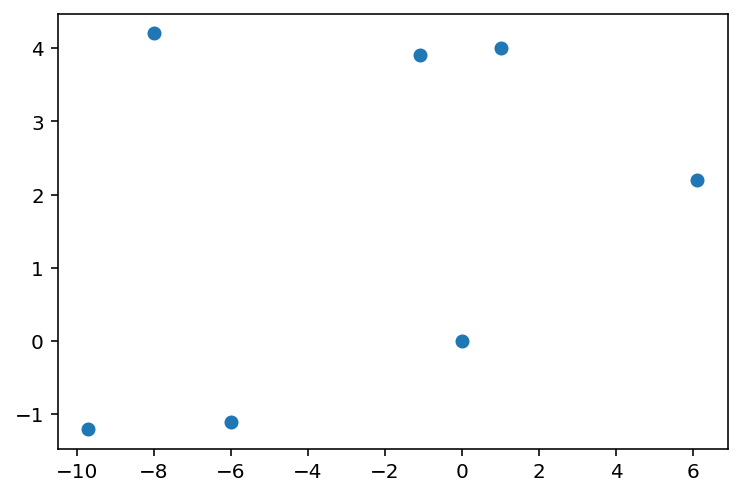

In [5]:
def fnorm(v):  ## v must be a np.array
    return np.sqrt(np.sum(v**2))
#puntos = np.random.rand(N+1,2)
plt.plot(puntos[:,0],puntos[:,1],'o')
dist = np.zeros((N+2,N+2))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  fnorm(puntos[i,:]-puntos[j,:])
        dist[i,j],dist[j,i] = aux,aux

for j in range(0,N+1):
    i = N+1
    aux  =  fnorm(puntos[0,:]-puntos[j,:])
    dist[i,j],dist[j,i] = aux,aux
print(dist)



 ## We transform the distances into integer numbers.

In [6]:
dist = np.floor(dist*1000)
print(dist)


[[    0.  4123.  6484.  6100.  9773.  9035.  4052.     0.]
 [ 4123.     0.  5408.  8660. 11896.  9002.  2102.  4123.]
 [ 6484.  5408.     0. 12541. 16161. 14241.  7397.  6484.]
 [ 6100.  8660. 12541.     0.  3701.  5664.  7000.  6100.]
 [ 9773. 11896. 16161.  3701.     0.  5661.  9998.  9773.]
 [ 9035.  9002. 14241.  5664.  5661.     0.  6906.  9035.]
 [ 4052.  2102.  7397.  7000.  9998.  6906.     0.  4052.]
 [    0.  4123.  6484.  6100.  9773.  9035.  4052.     0.]]


In [7]:
dmax = 0
for i in range(dist.shape[0]):
    dmax = dmax + np.max(dist[i,:])
bmax = int(np.log2(dmax)) + 1
print(dmax)
print(bmax)

100544.0
17


## We create the lists that will then serve us as indices in the sums

In [8]:
R = 5
lis_n = range(0,N+2)
lis_q = range(1,Q+1)
lis_r = range(R)
lis_h = range(bmax+1)

print("The number of qubits needed will be ",(N+2)**2*5*Q+(N+2)**2+Q*(bmax+1)+Q+(N+1)*Q+(N+2)**2)
## print("El numero de coeficientes de la matriz sera ",math.comb((N+2)**2*5*Q,2))

The number of qubits needed will be  820


In [9]:
# 6*(N+2)**2*Q

### We select the Lagrange Multipliers

In [10]:
lag_gen = 9500

lambda_1 = lag_gen
lambda_2 = lag_gen
lambda_2_ext = lag_gen
lambda_3 = lag_gen
lambda_3_ext = lag_gen
lambda_4 = lag_gen
lambda_5 = lag_gen
lambda_6 = lag_gen
lambda_7 = lag_gen

lambda_8aux = lag_gen
lambda_8 = lag_gen  ## Va ligada con la 4

lambda_9 = lag_gen

lambda_10_aux = lag_gen
lambda_10 = lag_gen ## Va ligada con la 1

lambda_11 = 1/1000

lambda_obj = 1/2

### We introduce the variables of our model.

In [11]:
# We create the variables of our model

## Variables x_{i,j,r,q}
coef = qubovert.QUBO()
for i in lis_n:
    for j in lis_n:
        for r in lis_r:
            for q in lis_q:
                coef.create_var(f"x_{i}_{j}_{r}_{q}")

## Variables a_{i,j}               
for i in lis_n:
    for j in lis_n:
        coef.create_var(f"a_{i}_{j}")
        

## Variables b_{h,q}
for h in lis_h:
    for q in range(2,Q+1):
        coef.create_var(f"b_{h}_{q}")
        
## Introducimos las variables auxiliares
for j in range(1,N+2):
    for q in lis_q:
        coef.create_var(f"aux1_{j}_{q}")

for i in lis_n:
    for j in lis_n:
        coef.create_var(f"aux2_{i}_{j}")
        

### We started to introduce our restrictions

In [12]:
## Restriction 1
for i in lis_n:
    for j in lis_n:
        for q in lis_q:
            for r in lis_r:
                coef[(f"x_{i}_{j}_{r}_{q}",)] += -2*(lambda_1)
                
                
for i in lis_n:
    for j in lis_n:
        for q in lis_q:
            for r1 in lis_r:
                for r2 in lis_r:
                    coef[(f"x_{i}_{j}_{r1}_{q}",f"x_{i}_{j}_{r2}_{q}")] +=  (lambda_1) 

                    
## Restriction 2
for q in lis_q:
    for j in range(1,N+2):
        coef[(f"x_{0}_{j}_{1}_{q}",)] = coef[(f"x_{0}_{j}_{1}_{q}",)] -2*lambda_2 
                
for q in lis_q:
    for j1 in range(1,N+2):
        for j2 in range(1,N+2):
            coef[(f"x_{0}_{j1}_{1}_{q}",f"x_{0}_{j2}_{1}_{q}")] = coef[(f"x_{0}_{j1}_{1}_{q}",f"x_{0}_{j2}_{1}_{q}")]+lambda_2 

    ## Restriction 2 extra
for q in lis_q:
    for i in range(0,N+2):
        coef[(f"x_{i}_{0}_{1}_{q}",)] = coef[(f"x_{i}_{0}_{1}_{q}",)] + lambda_2_ext
        

## Restriction 3
for q in lis_q:
    for i in range(0,N+1):
        coef[(f"x_{i}_{N+1}_{1}_{q}",)] = coef[(f"x_{i}_{N+1}_{1}_{q}",)] -2*lambda_3

for q in lis_q:
    for i1 in range(0,N+1):
        for i2 in range(0,N+1):
            coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")] = coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")]+lambda_3

    ## Restriction 3 extra
for q in lis_q:
    for j in range(N+2):
        coef[(f"x_{N+1}_{j}_{1}_{q}",)] = coef[(f"x_{N+1}_{j}_{1}_{q}",)] + lambda_3_ext  

        
## Restriction 4
for i in range(1,N+1):
    for q in lis_q:
        for j in range(1,N+2):
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*(lambda_4 )

for i in range(1,N+1):
    for q1 in lis_q:
        for j1 in range(1,N+2):
            for q2 in lis_q:
                for j2 in range(1,N+2):
                    coef[(f"x_{i}_{j1}_{1}_{q1}",f"x_{i}_{j2}_{1}_{q2}")] += (lambda_4)
            


## Restriction 5
for j in range(1,N+1):
    for q in lis_q:
        for i in range(0,N+1):
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*lambda_5

for j in range(1,N+1):
    for q1 in lis_q:
        for i1 in range(N+1):
            for q2 in lis_q:
                for i2 in range(N+1):
                    coef[(f"x_{i1}_{j}_{1}_{q1}",f"x_{i2}_{j}_{1}_{q2}")] += lambda_5 
            

## Restriction 6
for i in lis_n:
    for q in lis_q:
        coef[(f"x_{i}_{i}_{1}_{q}",)] = coef[(f"x_{i}_{i}_{1}_{q}",)] + lambda_6 


## Restriction 7
## We create a list in the special index
lis_r_aux  = [0,1,3]
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r in lis_r_aux:
                coef[(f"x_{i}_{j}_{r}_{q}",f"a_{i}_{j}")] +=  -2*lambda_7*Q 
    
for i in range(1,N+1):
    for j in range(1,N+1):
        for q1 in lis_q:
            for q2 in lis_q:
                for r1 in lis_r_aux:
                    for r2 in lis_r_aux:
                        coef[(f"x_{i}_{j}_{r1}_{q1}",f"x_{i}_{j}_{r2}_{q2}")] +=  lambda_7 

for i in range(1,N+1):
    for j in range(1,N+1):
        coef[(f"a_{i}_{j}",f"a_{i}_{j}")] +=  lambda_7*Q**2



## Pre Restriction 8 auxiliar
for j in range(1,N+2):
    for q in lis_q:
        for k1 in range(1,N+2):
            for k2 in range(1,N+2):
                coef[(f"x_{j}_{k1}_{1}_{q}",f"x_{j}_{k2}_{1}_{q}")] += lambda_8aux
        for k in range(1,N+2):
            coef[(f"x_{j}_{k}_{1}_{q}",f"aux1_{j}_{q}")] += -2*lambda_8aux
        coef[(f"aux1_{j}_{q}",)] += lambda_8aux
                
                

## Restriction 8
for i in range(N+1):
    for j in range(1,N+1):
        for q in lis_q:
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  lambda_8
            coef[(f"x_{i}_{j}_{1}_{q}",f"aux1_{j}_{q}")] +=  -lambda_8 



## Restriction 9
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r1 in lis_r_aux:
                for r2 in lis_r_aux:
                    coef[(f"x_{i}_{j}_{r1}_{q}",f"x_{j}_{i}_{r2}_{q}")] +=  lambda_9 
                    

## Restriction 10 aux
for i in lis_n:
    for j in lis_n:
        for r1 in lis_r_aux:
            for r2 in lis_r_aux:
                coef[(f"x_{i}_{j}_{r1}_{1}",f"x_{i}_{j}_{r2}_{1}")] +=  lambda_10_aux 
        for r in lis_r_aux:
            coef[(f"x_{i}_{j}_{r}_{1}",f"aux2_{i}_{j}")] += -2*lambda_10_aux
        coef[(f"aux2_{i}_{j}",)] += lambda_10_aux
                


## Restriction 10
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and j!=k and i!=k:
                coef[(f"aux2_{i}_{j}",f"aux2_{j}_{k}")] += lambda_10
                coef[(f"aux2_{i}_{j}",f"aux2_{i}_{k}")] -= lambda_10
                coef[(f"aux2_{j}_{k}",f"aux2_{i}_{k}")] -= lambda_10
                coef[(f"aux2_{i}_{k}",f"aux2_{i}_{k}")] +=  lambda_10


## Restriction to minimizing time
for q in range(2,Q+1):
    ## a^2
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{q}",f"x_{i2}_{j2}_{1}_{q}")] += lambda_11*dist[i1,j1]*dist[i2,j2]
    ## ab
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                coef[(f"x_{i}_{j}_{1}_{q}",f"b_{h}_{q}")] += lambda_11*2*2**h*dist[i,j]
    
    ## ac
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{1}",f"x_{i2}_{j2}_{1}_{q}")] += -2*lambda_11*dist[i1,j1]*dist[i2,j2]
    
    ## b^2
    for h1 in lis_h:
        for h2 in lis_h:
            coef[(f"b_{h1}_{q}",f"b_{h2}_{q}")] += lambda_11*2**(h1+h2)
    
    ## bc
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                coef[(f"x_{i}_{j}_{1}_{1}",f"b_{h}_{q}")] += -lambda_11*2*2**h*dist[i,j]
    
    ## c^2
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{1}",f"x_{i2}_{j2}_{1}_{1}")] += lambda_11*dist[i1,j1]*dist[i2,j2]
    
    
## Objective function
for i in lis_n:
    for j in lis_n:
        coef[(f"x_{i}_{j}_{1}_{1}",)] += lambda_obj * dist[i,j]

                

In [13]:
dwave_dic = {}
for i in coef:
    if len(i) == 1:
        dwave_dic[(i[0],i[0])] = coef[i]
    else:
        dwave_dic[i] = coef[i]
        
#dwave_dic

### We carry out the simulation

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


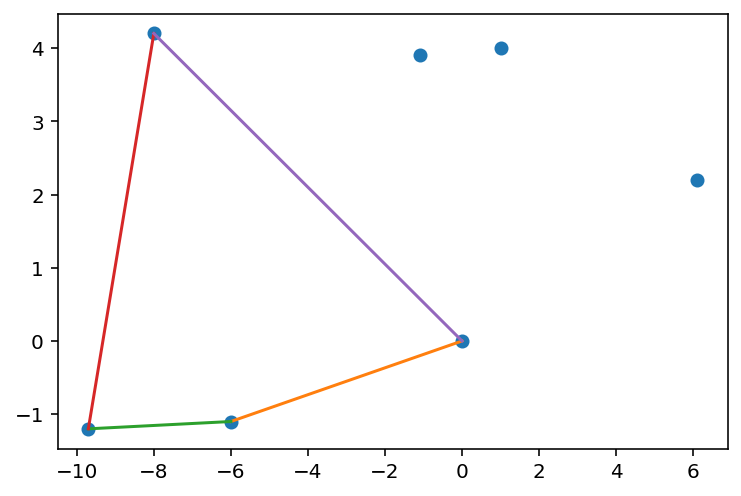

The robot  1  travels  24497.0
[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


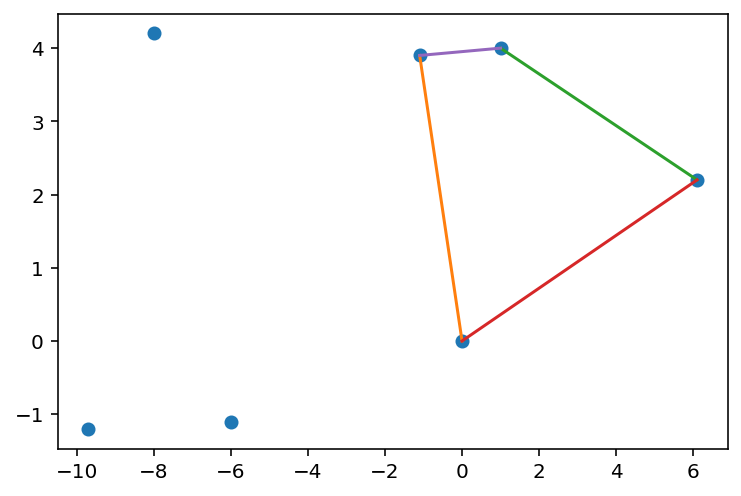

The robot  2  travels  18046.0


In [14]:
from neal import SimulatedAnnealingSampler
#from dwave.system import DWaveSampler, EmbeddingComposite


n_samples = 10000 # número de veces que ejecutamos el sistema


sampler = SimulatedAnnealingSampler()
#sampler = EmbeddingComposite(DWaveSampler())

#sampleset = sampler.sample_qubo(dwave_dic, num_reads = n_samples,auto_scale=True,postprocess = "optimization")
sampleset = sampler.sample_qubo(dwave_dic, num_reads = n_samples,auto_scale=True)

solution = sampleset.first.sample

## Mejor energia
#print(sampleset.first.energy)
## Matriz solucion
for q in lis_q:
    mat_sol = np.zeros((N+2,N+2))
    for i in  range(N+2):
        for j in range(N+2):
            if solution[f"x_{i}_{j}_{1}_{q}"] == 1:
                mat_sol[i,j] = 1
    print(mat_sol)
    
    ## Pintamos el camino propuesto
    plt.plot(puntos[:,0],puntos[:,1],'o')
    vaux = np.array(list(range(N+2)))
    suma_ruta = 0
    for i in range(N+1):
        sig_aux = mat_sol[i,:]==1
        if np.sum(sig_aux) > 0:
            sig = (int(vaux[sig_aux][0]))%(N+1)
            plt.plot(puntos[(i,sig),0],puntos[(i,sig),1])
            suma_ruta += np.floor(1000*fnorm(puntos[i,:]-puntos[sig,:]))
    plt.show()
    print("The robot ",q," travels ",suma_ruta)


We try to show all the graphics in it.

### We show the paths of the robots


range(1, 3)
The robot  1  travels  24497.0
The robot  2  travels  18046.0

[[ 0.   0. ]
 [ 1.   4. ]
 [ 6.1  2.2]
 [-6.  -1.1]
 [-9.7 -1.2]
 [-8.   4.2]
 [-1.1  3.9]]


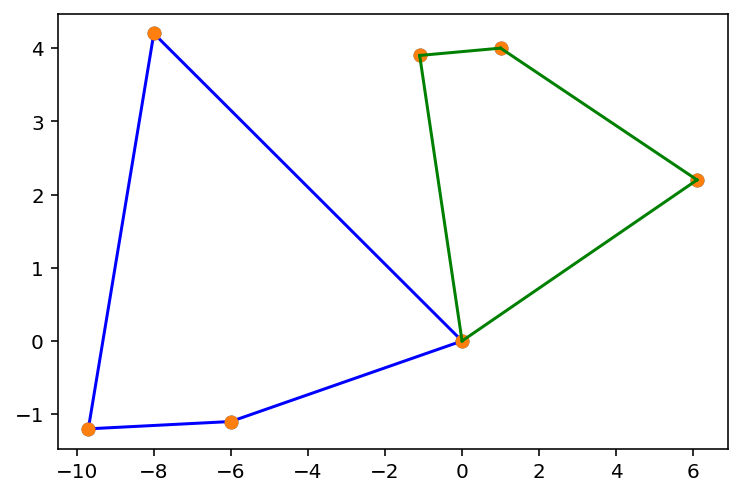

In [15]:
## Mejor energia
#print(sampleset.first.energy)
## Matriz solucion
print()
print(lis_q)
colores = ["b","g","r"]
sol = np.zeros((N+2,N+2))
sol2 = np.zeros((N+2,N+2))
for q in lis_q:
    mat_sol = np.zeros((N+2,N+2))
    for i in  range(N+2):
        for j in range(N+2):
            if solution[f"x_{i}_{j}_{1}_{q}"] == 1:
                mat_sol[i%len(puntos),j%len(puntos)] = 1
     
    sol += mat_sol
    sol2 += mat_sol * (q-1)
    #print(mat_sol)
    
    ## Let us print the path
    plt.plot(puntos[:,0],puntos[:,1],'o')
    vaux = np.array(list(range(N+2)))
    suma_ruta = 0
    for i in range(N+1):
        sig_aux = mat_sol[i,:]==1
        if np.sum(sig_aux) > 0:
            sig = (int(vaux[sig_aux][0]))%(N+1)
            plt.plot(puntos[(i,sig),0],puntos[(i,sig),1],colores[q-1])
            suma_ruta += np.floor(1000*fnorm(puntos[i,:]-puntos[sig,:]))
    #plt.show()
    print("The robot ",q," travels ",suma_ruta)
print()
print(puntos)

In [16]:
sol2

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

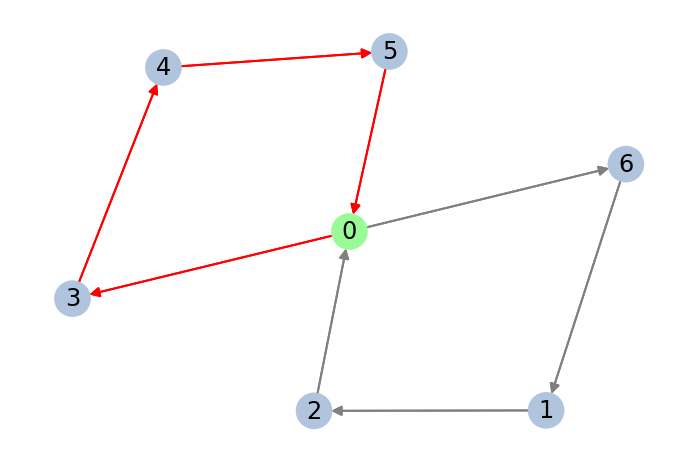

In [17]:
import numpy as np
import networkx as nx

colores = ["r","grey","y"]

G = nx.DiGraph()
rows, cols = np.where(sol == 1)
edges = list(zip(rows.tolist(), cols.tolist()))
edges2 = [(x[0], x[1]%len(puntos)) for x in edges]

#pos2 = {int(i): puntos[i] for i in range(len(puntos))} #position of given points...

G.add_edges_from(edges2)
pos2 = nx.spring_layout(G) #PARFAIT
nx.draw_networkx_labels(G, pos2)
values = [colores[int(sol2[x[0], x[1]])] for x in G.edges]

nx.draw_networkx_edges(G, pos2, edge_color = values)

node_colors = ["lightsteelblue" for _ in range(len(G.nodes))]
node_colors[0] = "palegreen"

nx.draw(G, pos2, edge_color=values, node_color = node_colors)
plt.show()

In [18]:
edges2

[(0, 3), (0, 6), (1, 2), (2, 0), (3, 4), (4, 5), (5, 0), (6, 1)]

# Verification of restrictions.
The following code checks which constraints are satisfied and which are not.

In [19]:
best_energy = 0

## Restriction 1
val_res1 = 0
for i in lis_n:
    for j in lis_n:
        for q in lis_q:
            for r in lis_r:
                val_res1 += -2*solution[f"x_{i}_{j}_{r}_{q}"] 
                
            for r1 in lis_r:
                for r2 in lis_r:
                    val_res1 += solution[f"x_{i}_{j}_{r1}_{q}"]*solution[f"x_{i}_{j}_{r2}_{q}"]
print("Constraint 1 is providing ",val_res1*lambda_1, " and should be ",-lambda_1*(N+2)**2*Q)                  
best_energy += val_res1*lambda_1



## Restriction 2
val_res2 = 0
for q in lis_q:
    for j in range(1,N+2):
        #coef[(f"x_{0}_{j}_{1}_{q}",)] = coef[(f"x_{0}_{j}_{1}_{q}",)] -2*lambda_2 
        val_res2 += -2*solution[f"x_{0}_{j}_{1}_{q}"]*solution[f"x_{0}_{j}_{1}_{q}"]
                
    for j1 in range(1,N+2):
        for j2 in range(1,N+2):
            val_res2 += solution[f"x_{0}_{j1}_{1}_{q}"]*solution[f"x_{0}_{j2}_{1}_{q}"]
print("Constraint 2 is providing ",lambda_2*val_res2, " and should be ",-lambda_2*Q)
best_energy += val_res2*lambda_2
            
    ## Restriction 2 extra
val_res2_ext = 0
for q in lis_q:
    for i in range(0,N+2):
        val_res2_ext += solution[f"x_{i}_{0}_{1}_{q}"]
print("Constraint 2 is providing ",lambda_2_ext*val_res2_ext)
best_energy += val_res2_ext*lambda_2_ext
        
    
## Restriction 3
val_res3 = 0
for q in lis_q:
    for i in range(0,N+1):
        val_res3 += -2*solution[f"x_{i}_{N+1}_{1}_{q}"]

    for i1 in range(0,N+1):
        for i2 in range(0,N+1):
            #coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")] = coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")]+lambda_3
            val_res3 += solution[f"x_{i1}_{N+1}_{1}_{q}"]*solution[f"x_{i2}_{N+1}_{1}_{q}"]
print("Constraint 3 is providing",lambda_3*val_res3, "and should be ",-lambda_3*Q)  
best_energy += val_res3*lambda_3
            
    ## Restriction 3 extra
val_res3_ext = 0
for q in lis_q:
    for j in range(N+2):
        #coef[(f"x_{N+1}_{j}_{1}_{q}",)] = coef[(f"x_{N+1}_{j}_{1}_{q}",)] + lambda_3_ext  
        val_res3_ext += solution[f"x_{N+1}_{j}_{1}_{q}"]
        
print("Constraint extra 3 is providing ",val_res3_ext*lambda_3_ext)
best_energy += val_res3_ext*lambda_3_ext
        

## Restriction 4
val_res4 = 0
for i in range(1,N+1):
    for q in lis_q:
        for j in range(1,N+2):
            #coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*(lambda_4 )
            val_res4 += -2*solution[f"x_{i}_{j}_{1}_{q}"]

    for q1 in lis_q:
        for j1 in range(1,N+2):
            for q2 in lis_q:
                for j2 in range(1,N+2):
                    val_res4 += solution[f"x_{i}_{j1}_{1}_{q1}"]*solution[f"x_{i}_{j2}_{1}_{q2}"]

print("Constraint 4 is providing ",val_res4*lambda_4, " and should be ",-lambda_4*N)
best_energy += val_res4*lambda_4
                    

## Restriction 5
val_res5 = 0
for j in range(1,N+1):
    for q in lis_q:
        for i in range(0,N+1):
            #coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*lambda_5
            val_res5 += -2*solution[f"x_{i}_{j}_{1}_{q}"]

    for q1 in lis_q:
        for i1 in range(N+1):
            for q2 in lis_q:
                for i2 in range(N+1):
                    #coef[(f"x_{i1}_{j}_{1}_{q1}",f"x_{i2}_{j}_{1}_{q2}")] += lambda_5 
                    val_res5 += solution[f"x_{i1}_{j}_{1}_{q1}"]*solution[f"x_{i2}_{j}_{1}_{q2}"]
print("Constraint 5 is providing ", lambda_5*val_res5, " and should be ",-lambda_5*N)
best_energy += val_res5*lambda_5
  
    
    
                
## Restriction 6
val_res6 = 0
for i in lis_n:
    for q in lis_q:
        #coef[(f"x_{i}_{i}_{1}_{q}",)] = coef[(f"x_{i}_{i}_{1}_{q}",)] + lambda_6 
        val_res6 += solution[f"x_{i}_{i}_{1}_{q}"]
print("The value of the Constraint 6 is: ",val_res6*lambda_6)
best_energy += val_res6*lambda_6
        
## Restriction 7
## We create a list in the special index
val_res7 = 0
lis_r_aux  = [0,1,3]
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r in lis_r_aux:
                #coef[(f"x_{i}_{j}_{r}_{q}",f"a_{i}_{j}")] +=  -2*lambda_7*Q 
                val_res7  += -2*Q*solution[f"x_{i}_{j}_{r}_{q}"]*solution[f"a_{i}_{j}"]
    
        for q1 in lis_q:
            for q2 in lis_q:
                for r1 in lis_r_aux:
                    for r2 in lis_r_aux:
                        #coef[(f"x_{i}_{j}_{r1}_{q}",f"x_{i}_{j}_{r2}_{q}")] +=  lambda_7 
                        val_res7 += solution[f"x_{i}_{j}_{r1}_{q1}"]*solution[f"x_{i}_{j}_{r2}_{q2}"]

        #coef[(f"a_{i}_{j}",f"a_{i}_{j}")] +=  lambda_7*Q**2
        val_res7 += solution[f"a_{i}_{j}"]*Q**2
print("The value of the Constraint 7 is ",val_res7*lambda_7)
best_energy += val_res7*lambda_7
        

## Pre Restriction 8 auxiliar
val_res8aux = 0
for j in range(1,N+2):
    for q in lis_q:
        for k1 in range(1,N+2):
            for k2 in range(1,N+2):
                val_res8aux += solution[f"x_{j}_{k1}_{1}_{q}"]*solution[f"x_{j}_{k2}_{1}_{q}"]*lambda_8aux
        for k in range(1,N+2):
            val_res8aux += solution[f"x_{j}_{k}_{1}_{q}"]*solution[f"aux1_{j}_{q}"] * (-2*lambda_8aux)
        val_res8aux += solution[f"aux1_{j}_{q}"]*lambda_8aux
print("The ancilla constraint 8 is ",val_res8aux)
best_energy += val_res8aux
                
                

## Restriction 8
val_res8 = 0
for i in range(N+1):
    for j in range(1,N+1):
        for q in lis_q:
            val_res8 += solution[f"x_{i}_{j}_{1}_{q}"]*lambda_8
            val_res8 += solution[f"x_{i}_{j}_{1}_{q}"]*solution[f"aux1_{j}_{q}"]*(-lambda_8) 
print("The value of the Constraint 8 is ",val_res8)
best_energy += val_res8


## Restriction 9
val_res9 = 0
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r1 in lis_r_aux:
                for r2 in lis_r_aux: 
                    val_res9 += solution[f"x_{i}_{j}_{r1}_{q}"]*solution[f"x_{j}_{i}_{r2}_{q}"]
   
print("The value of the constraint 9 is:",val_res9*lambda_9)
best_energy += val_res9*lambda_9


## Restriction 10
## Vamos a necesitar introducir 4 multi-bucles


## Restriction 10 aux
val_res10aux = 0
for i in lis_n:
    for j in lis_n:
        for r1 in lis_r_aux:
            for r2 in lis_r_aux:
                val_res10aux += solution[f"x_{i}_{j}_{r1}_{1}"]*solution[f"x_{i}_{j}_{r2}_{1}"]* lambda_10_aux 
        for r in lis_r_aux:
            val_res10aux += solution[f"x_{i}_{j}_{r}_{1}"]*solution[f"aux2_{i}_{j}"] * (-2*lambda_10_aux)
        val_res10aux += solution[f"aux2_{i}_{j}"] * lambda_10_aux
                


## Restriction 10
val_res10 = 0
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and j!=k and i!=k:
                val_res10 += solution[f"aux2_{i}_{j}"]*solution[f"aux2_{j}_{k}"]*lambda_10
                val_res10 += -solution[f"aux2_{i}_{j}"]*solution[f"aux2_{i}_{k}"] * lambda_10
                val_res10 += -solution[f"aux2_{j}_{k}"]*solution[f"aux2_{i}_{k}"] * lambda_10
                val_res10 += solution[f"aux2_{i}_{k}"]*solution[f"aux2_{i}_{k}"] *  lambda_10

                       

print("The value of the constraint 10 is: ",val_res10*lambda_10)
best_energy += val_res10*lambda_10


## Restriction to minimize time
val_res11 = 0
for q in range(2,Q+1):
    ## a^2
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    val_res11 += solution[f"x_{i1}_{j1}_{1}_{q}"]*solution[f"x_{i2}_{j2}_{1}_{q}"]* lambda_11*dist[i1,j1]*dist[i2,j2]
                     
    ## ab
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                val_res11 += solution[f"x_{i}_{j}_{1}_{q}"]*solution[f"b_{h}_{q}"] * lambda_11*2*2**h*dist[i,j]
    
    ## ac
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    val_res11 += solution[f"x_{i1}_{j1}_{1}_{1}"]*solution[f"x_{i2}_{j2}_{1}_{q}"] *(-2)*lambda_11*dist[i1,j1]*dist[i2,j2]
    
    ## b^2
    for h1 in lis_h:
        for h2 in lis_h:
            val_res11 += solution[f"b_{h1}_{q}"]*solution[f"b_{h2}_{q}"] * lambda_11*2**(h1+h2)
    
    ## bc
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                val_res11 += solution[f"x_{i}_{j}_{1}_{1}"]*solution[f"b_{h}_{q}"] * (-lambda_11)*2*2**h*dist[i,j]
    
    ## c^2
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    val_res11 += solution[f"x_{i1}_{j1}_{1}_{1}"]*solution[f"x_{i2}_{j2}_{1}_{1}"] * lambda_11*dist[i1,j1]*dist[i2,j2]
    
    

                

print("Constraint 11 is providingo a best_energy ",val_res11, " y deberia ser ",0)
best_energy += val_res11

## Objective function
val_obj = 0
for i in lis_n:
    for j in lis_n:
        val_obj += solution[f"x_{i}_{j}_{1}_{1}"] *lambda_obj * dist[i,j]

print("the objective function is: ",val_obj)



print("Our energy is: ",best_energy)
print("The sampleset energy is: ",sampleset.first.energy)

Constraint 1 is providing  -1216000  and should be  -1216000
Constraint 2 is providing  -19000  and should be  -19000
Constraint 2 is providing  0
Constraint 3 is providing -19000 and should be  -19000
Constraint extra 3 is providing  0
Constraint 4 is providing  -57000  and should be  -57000
Constraint 5 is providing  -57000  and should be  -57000
The value of the Constraint 6 is:  0
The value of the Constraint 7 is  0
The ancilla constraint 8 is  0
The value of the Constraint 8 is  0
The value of the constraint 9 is: 0
The value of the constraint 10 is:  0
Constraint 11 is providingo a best_energy  0.1690000001108274  y deberia ser  0
the objective function is:  12248.5
Our energy is:  -1367999.8309999998
The sampleset energy is:  -1355751.3309999108
